In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# devemos primeiramente ler o dataset e separar as amostras dos rotulos
df = pd.read_csv("data/creditcard.csv")

# tive problemas dado o tamanho do dataset utilizado, logo tive que reduzir
# o dataset tem a característica de que os dados de classe 1 são anomalias ou outliers
tam_dataset = 10000

df1 = df[df['Class']==1]
df2 = df[df['Class']==0]

# aux = int((perc_dataset/100)*len(df))-len(df1)
aux = tam_dataset-len(df1)
print(f'Tamanho dataset: {aux+len(df1)}')

df_aux = df2.iloc[:aux, :]
df = pd.concat([df1, df_aux])

# print(df.head())

x = df.iloc[:, :-1]  # tirar a última coluna
y = df.iloc[:, -1]   # somente última coluna (rotulos)

class_perc = df.value_counts('Class')
n_samples = len(df)

for i,item in enumerate(class_perc):
    print(f'Class {i}: {item} ({round(item/n_samples * 100, 2)}%)')

Tamanho dataset: 10000
Class 0: 9508 (95.08%)
Class 1: 492 (4.92%)


In [2]:
# devemos separar o dataset em 2 conjuntos: treino, testes
# para isso utilizaremos a tecnica do sklearn para dividir os conjuntos de forma balanceada

# dividir primeiro entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y)

print(f'Número de amostras do dataset: {len(x)} (100%)')
print(f'Tamanho do conjunto de treino: {len(x_train)} ({round(len(x_train)*100/len(x),2)}%)')
print(f'Tamanho do conjunto de testes: {len(x_test)} ({round(len(x_test)*100/len(x),2)}%)')

class_perc_train = y_train.value_counts()
n_samples_train = len(y_train)
for i,item in enumerate(class_perc_train):
    print(f'Treinamento Class {i}: {item} ({round(item/n_samples_train * 100, 2)}%)')

Número de amostras do dataset: 10000 (100%)
Tamanho do conjunto de treino: 9000 (90.0%)
Tamanho do conjunto de testes: 1000 (10.0%)
Treinamento Class 0: 8557 (95.08%)
Treinamento Class 1: 443 (4.92%)


In [10]:
# grid de parametros a serem testados
# ex: o kernel polinomial sera testado com todas as combinacoes de C e dos graus (degree) -> (C=0.1,degree=2),(C=1, degree=3)...
# o kernel rbf (Gaussiano) sera testado com todas as combinacoes  de C
param_grid = [
    {'kernel':['poly'], 'C':[0.1, 1, 10], 'degree':[2, 3, 4]},
    {'kernel':['rbf'], 'C':[0.1, 1, 10], 'gamma':['scale']}, # 'gamma':['scale', 0.01, 0.0001] # podemos colocar a variancia que desejarmos
    {'kernel':['sigmoid'], 'C':[0.1, 1, 10], 'gamma':['scale']},
    {'kernel':['linear'], 'C': [0.1, 1, 10]}
]

# criando instancia da SVM
svc = SVC(verbose=False)
# gridsearch treina a SVM com combinacoes diferentes especificados em param_grid
# escolhemos a acuracia para medir o desempenho de cada um dos modelos treinados
# grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search = GridSearchCV(svc, param_grid, scoring='accuracy')
grid_search.fit(x_train, y_train)

# tambem e possivel treinar cada modelo separadamente, avaliar cada um dos modelos e em sequencia escolher o melhor
# svc = SVC(kernel='linear', C=0.1, verbose=False)
# svc = SVC(kernel='poly', degree=4, C=10)
# svc = SVC(kernel='rbf', C=1, gamma=0.01) # gamma neste caso e a variancia
# svc.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 10], 'gamma': ['scale'],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10], 'gamma': ['scale'],
                          'kernel': ['sigmoid']},
                         {'C': [0.1, 1, 10], 'kernel': ['linear']}],
             scoring='accuracy')

In [28]:
# capturar os melhores resultados, tanto melhor SVM quanto os seus parâmetros
# tambem e possivel capturar os resultados, no caso o escolhido foi acuracia
best_svm = grid_search.best_estimator_
best_params = grid_search.best_params_
results = grid_search.cv_results_

print("Melhor classificador SVM:")
print(f'\t {best_svm}')
print("Melhores parâmetros:")
print(f'\t {best_params}')

param_C = results['param_C']
param_kernel = results['param_kernel']
param_degree = results['param_degree']
param_gamma = results['param_gamma']
mean_acc_kfold = results['mean_test_score']

cont = 1
for C, kernel, degree, gamma, acc in zip(param_C, param_kernel, param_degree, param_gamma, mean_acc_kfold):
    key = f"kernel={kernel}, C={C}"
    if kernel == 'poly':
        key += f", degree={degree}"
    if kernel in ('rbf', 'sigmoid'):
        key += f", gamma={gamma}"
    print(f'Combinação {cont} => {key} => Acurácia Média: {acc}')
    cont += 1

# y_pred = svc.predict(x_test)
y_pred = best_svm.predict(x_test)

# obtendo metricas de avaliacao
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Test Acurracy: {accuracy}')
print(f'Test MSE: {mse}')

Melhor classificador SVM:
	 SVC(C=0.1, kernel='linear')
Melhores parâmetros:
	 {'C': 0.1, 'kernel': 'linear'}
Combinação 1 => kernel=poly, C=0.1, degree=2 => Acurácia Média: 0.9944444444444445
Combinação 2 => kernel=poly, C=0.1, degree=3 => Acurácia Média: 0.9944444444444445
Combinação 3 => kernel=poly, C=0.1, degree=4 => Acurácia Média: 0.9944444444444445
Combinação 4 => kernel=poly, C=1, degree=2 => Acurácia Média: 0.9946666666666667
Combinação 5 => kernel=poly, C=1, degree=3 => Acurácia Média: 0.9946666666666667
Combinação 6 => kernel=poly, C=1, degree=4 => Acurácia Média: 0.9945555555555556
Combinação 7 => kernel=poly, C=10, degree=2 => Acurácia Média: 0.9947777777777779
Combinação 8 => kernel=poly, C=10, degree=3 => Acurácia Média: 0.9947777777777776
Combinação 9 => kernel=poly, C=10, degree=4 => Acurácia Média: 0.9951111111111111
Combinação 10 => kernel=rbf, C=0.1, gamma=scale => Acurácia Média: 0.9944444444444445
Combinação 11 => kernel=rbf, C=1, gamma=scale => Acurácia Média: 0

Classes: [0 1]


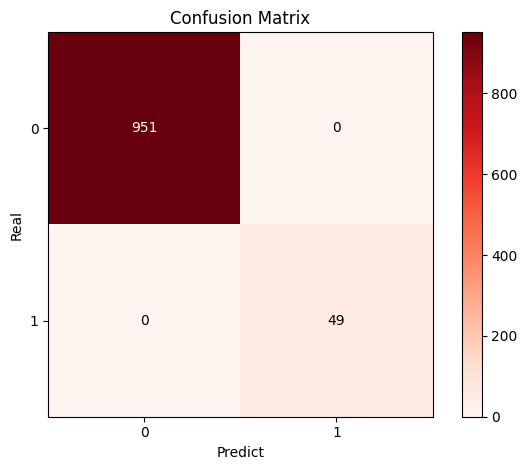

In [29]:
# matriz de confusao
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(y_test)
print(f'Classes: {classes}')

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Adicionar valores aos quadrados da matriz de confusao
lim_color_black = 600  # mudar cor da letra para branco caso a cor do vermelho fique muito escura
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > lim_color_black else "black")

plt.ylabel('Real')
plt.xlabel('Predict')
plt.tight_layout()
plt.show()